In [ ]:
#!pip install seaborn
#!pip install umap-learn
#!pip install mygene
#!pip install biomart
#!pip install gseapy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import requests

import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score



c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\sklearn\cluster\_kmeans.py:14

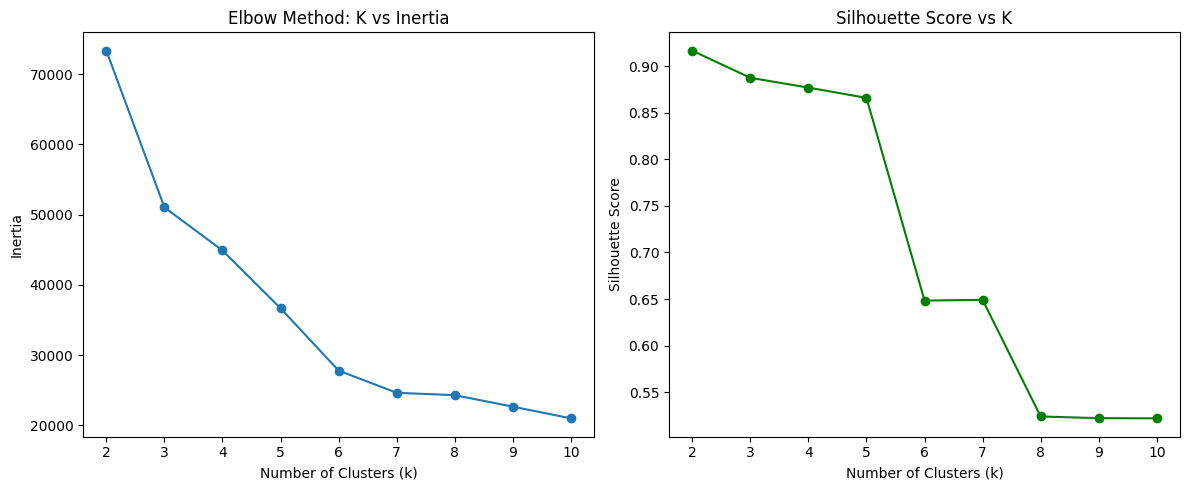

c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\smkts\anaconda3\envs\sams_death\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


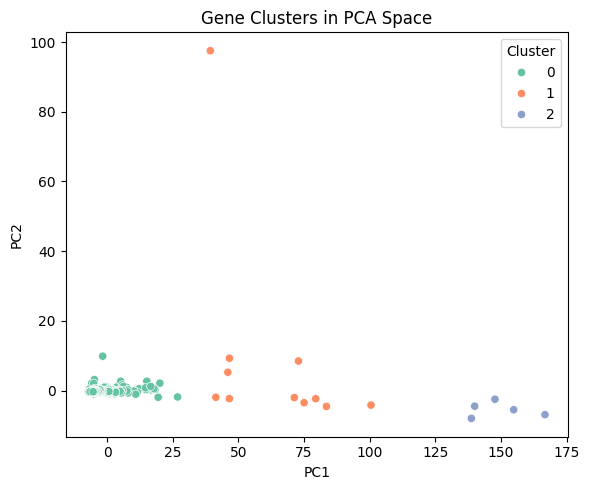

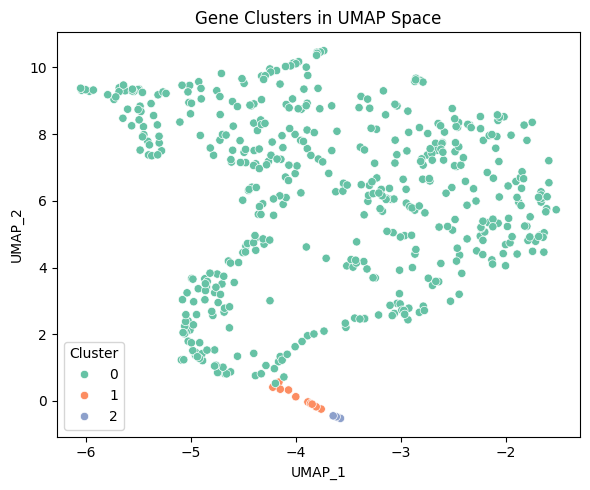

In [17]:
# Seed for reproducibility
np.random.seed(30)

# Load data
df = pd.read_csv("top_variable_genes_tpm.csv")
df.set_index(df.columns[0], inplace=True)

# Transpose so that genes are rows and samples are columns
df_genes = df.T

# Standardize gene expression across samples
scaler = StandardScaler()
X_genes_scaled = scaler.fit_transform(df_genes)

# -----------------------
# Elbow Method & Silhouette Score
# -----------------------
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=30)
    labels = kmeans.fit_predict(X_genes_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_genes_scaled, labels))

# Plot Elbow and Silhouette Score
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(k_values, inertia, marker='o')
axs[0].set_title('Elbow Method: K vs Inertia')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Inertia')

axs[1].plot(k_values, silhouette_scores, marker='o', color='green')
axs[1].set_title('Silhouette Score vs K')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# -----------------------
# PCA for Visualization (optional)
# -----------------------
pca = PCA(n_components=2)
X_genes_pca = pca.fit_transform(X_genes_scaled)

# -----------------------
# UMAP (on full standardized space)
# -----------------------
umap_model = umap.UMAP(random_state=42)
X_umap = umap_model.fit_transform(X_genes_scaled)

# -----------------------
# KMeans on PCA or original space (you decide)
# -----------------------
optimal_k = 3  # choose based on elbow/silhouette
kmeans_genes = KMeans(n_clusters=optimal_k, random_state=30)
gene_clusters = kmeans_genes.fit_predict(X_genes_scaled)

# -----------------------
# Create result DataFrame
# -----------------------
gene_cluster_df = pd.DataFrame({
    'Gene': df_genes.index,
    'PC1': X_genes_pca[:, 0],
    'PC2': X_genes_pca[:, 1],
    'UMAP_1': X_umap[:, 0],
    'UMAP_2': X_umap[:, 1],
    'Cluster': gene_clusters
}).set_index('Gene')

# -----------------------
# Visualize PCA Clusters
# -----------------------
plt.figure(figsize=(6, 5))
sns.scatterplot(data=gene_cluster_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Gene Clusters in PCA Space')
plt.tight_layout()
plt.show()

# -----------------------
# Visualize UMAP Clusters
# -----------------------
plt.figure(figsize=(6, 5))
sns.scatterplot(data=gene_cluster_df, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Set2')
plt.title('Gene Clusters in UMAP Space')
plt.tight_layout()
plt.show()


In [18]:
gene_cluster_df

,PC1,PC2,UMAP_1,UMAP_2,Cluster
Gene,,,,,
ENSG00000211592.8,39.288107,97.511799,-4.163992,0.565353,1
ENSG00000210082.2,139.956991,-4.449243,-3.585271,-0.513431,2
ENSG00000198712.1,154.808607,-5.486422,-3.595373,-0.498675,2
ENSG00000210196.2,72.853499,8.491577,-4.003408,0.126745,1
ENSG00000198804.2,166.724910,-6.888661,-3.578204,-0.521224,2
...,...,...,...,...,...
ENSG00000100804.19,-5.683462,-0.225142,-4.126175,7.595992,0
ENSG00000204983.14,-7.050517,-0.370166,-5.644604,9.471744,0
ENSG00000188488.14,-6.815243,-0.317364,-5.794457,9.182486,0


In [ ]:
# X_genes_scaled is the standardized expression data
# gene_clusters are the cluster labels from KMeans
dbi = davies_bouldin_score(X_genes_pca, gene_clusters)
print(f"Davies-Bouldin Index: {dbi}")

Davies-Bouldin Index: 0.43419324410658655


In [20]:
# Calculate Silhouette Score (higher values indicate better clustering)
silhouette = silhouette_score(X_genes_pca, gene_clusters)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.9244794449595676


In [ ]:
# GO ANALYSIS

In [ ]:
def get_gene_name(ensembl_id):
    base_id = ensembl_id.split('.')[0]
    url = f"https://rest.ensembl.org/lookup/id/{base_id}?content-type=application/json"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json().get("display_name", "Not Found")
    return "Not Found"

# Assuming gene_cluster_df is your dataframe and Ensembl IDs are in the index
ensembl_ids = gene_cluster_df.index.tolist()

# Fetch gene names for all Ensembl IDs
gene_names = [get_gene_name(gene_id) for gene_id in ensembl_ids]

# Add gene names as a new column
gene_cluster_df['Gene Name'] = gene_names

# Display the updated dataframe
print(gene_cluster_df)


                           PC1        PC2    UMAP_1    UMAP_2  Cluster  \
Gene                                                                     
ENSG00000211592.8    39.288107  97.511799 -4.163992  0.565353        1   
ENSG00000210082.2   139.956991  -4.449243 -3.585271 -0.513431        2   
ENSG00000198712.1   154.808607  -5.486422 -3.595373 -0.498675        2   
ENSG00000210196.2    72.853499   8.491577 -4.003408  0.126745        1   
ENSG00000198804.2   166.724910  -6.888661 -3.578204 -0.521224        2   
...                        ...        ...       ...       ...      ...   
ENSG00000100804.19   -5.683462  -0.225142 -4.126175  7.595992        0   
ENSG00000204983.14   -7.050517  -0.370166 -5.644604  9.471744        0   
ENSG00000188488.14   -6.815243  -0.317364 -5.794457  9.182486        0   
ENSG00000142871.18   -6.402236  -0.282138 -4.515791  9.663871        0   
ENSG00000183255.12   -5.319330  -0.319926 -2.490000  8.461479        0   

                   Gene Name  
Gene  

In [ ]:
gene_cluster_df.to_csv('gene_cluster.csv', index=False)

In [ ]:
#cluster 0

In [23]:
# Filter genes in cluster 0
cluster_0_genes = gene_cluster_df[gene_cluster_df['Cluster'] == 0]['Gene Name'].tolist()

In [38]:
# Perform GO enrichment analysis
enr_cluster_0 = gp.enrichr(
    gene_list=cluster_0_genes,
    gene_sets='GO_Biological_Process_2018',  # You can use different gene sets like BP, MF, CC
    organism='Human',  # Use 'Human' for human genes
    cutoff=0.05  # Only show results with p-value < 0.05
)

# View results
enr_cluster_0.results.head()  # Display top enriched GO terms

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,SRP-dependent cotranslational protein targetin...,70/89,1.279125e-97,3.009781e-94,0,0,176.110681,39291.099184,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...
1,GO_Biological_Process_2018,cotranslational protein targeting to membrane ...,70/93,3.891660e-95,4.578538e-92,0,0,145.452899,31619.532620,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...
2,GO_Biological_Process_2018,protein targeting to ER (GO:0045047),70/97,7.088314e-93,5.559601e-90,0,0,123.878903,26284.869284,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...
3,GO_Biological_Process_2018,"nuclear-transcribed mRNA catabolic process, no...",69/112,6.465038e-84,3.803058e-81,0,0,76.422983,14638.878846,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...
4,GO_Biological_Process_2018,viral gene expression (GO:0019080),68/110,7.645029e-83,3.597751e-80,0,0,76.924506,14544.924676,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP1;R...


In [39]:
# Extract the results from Enrichr
enrichment_results = enr_cluster_0.results

C:\Users\smkts\AppData\Local\Temp\ipykernel_49864\919431687.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='P-value', y='Term', data=enrichment_results, palette='viridis')


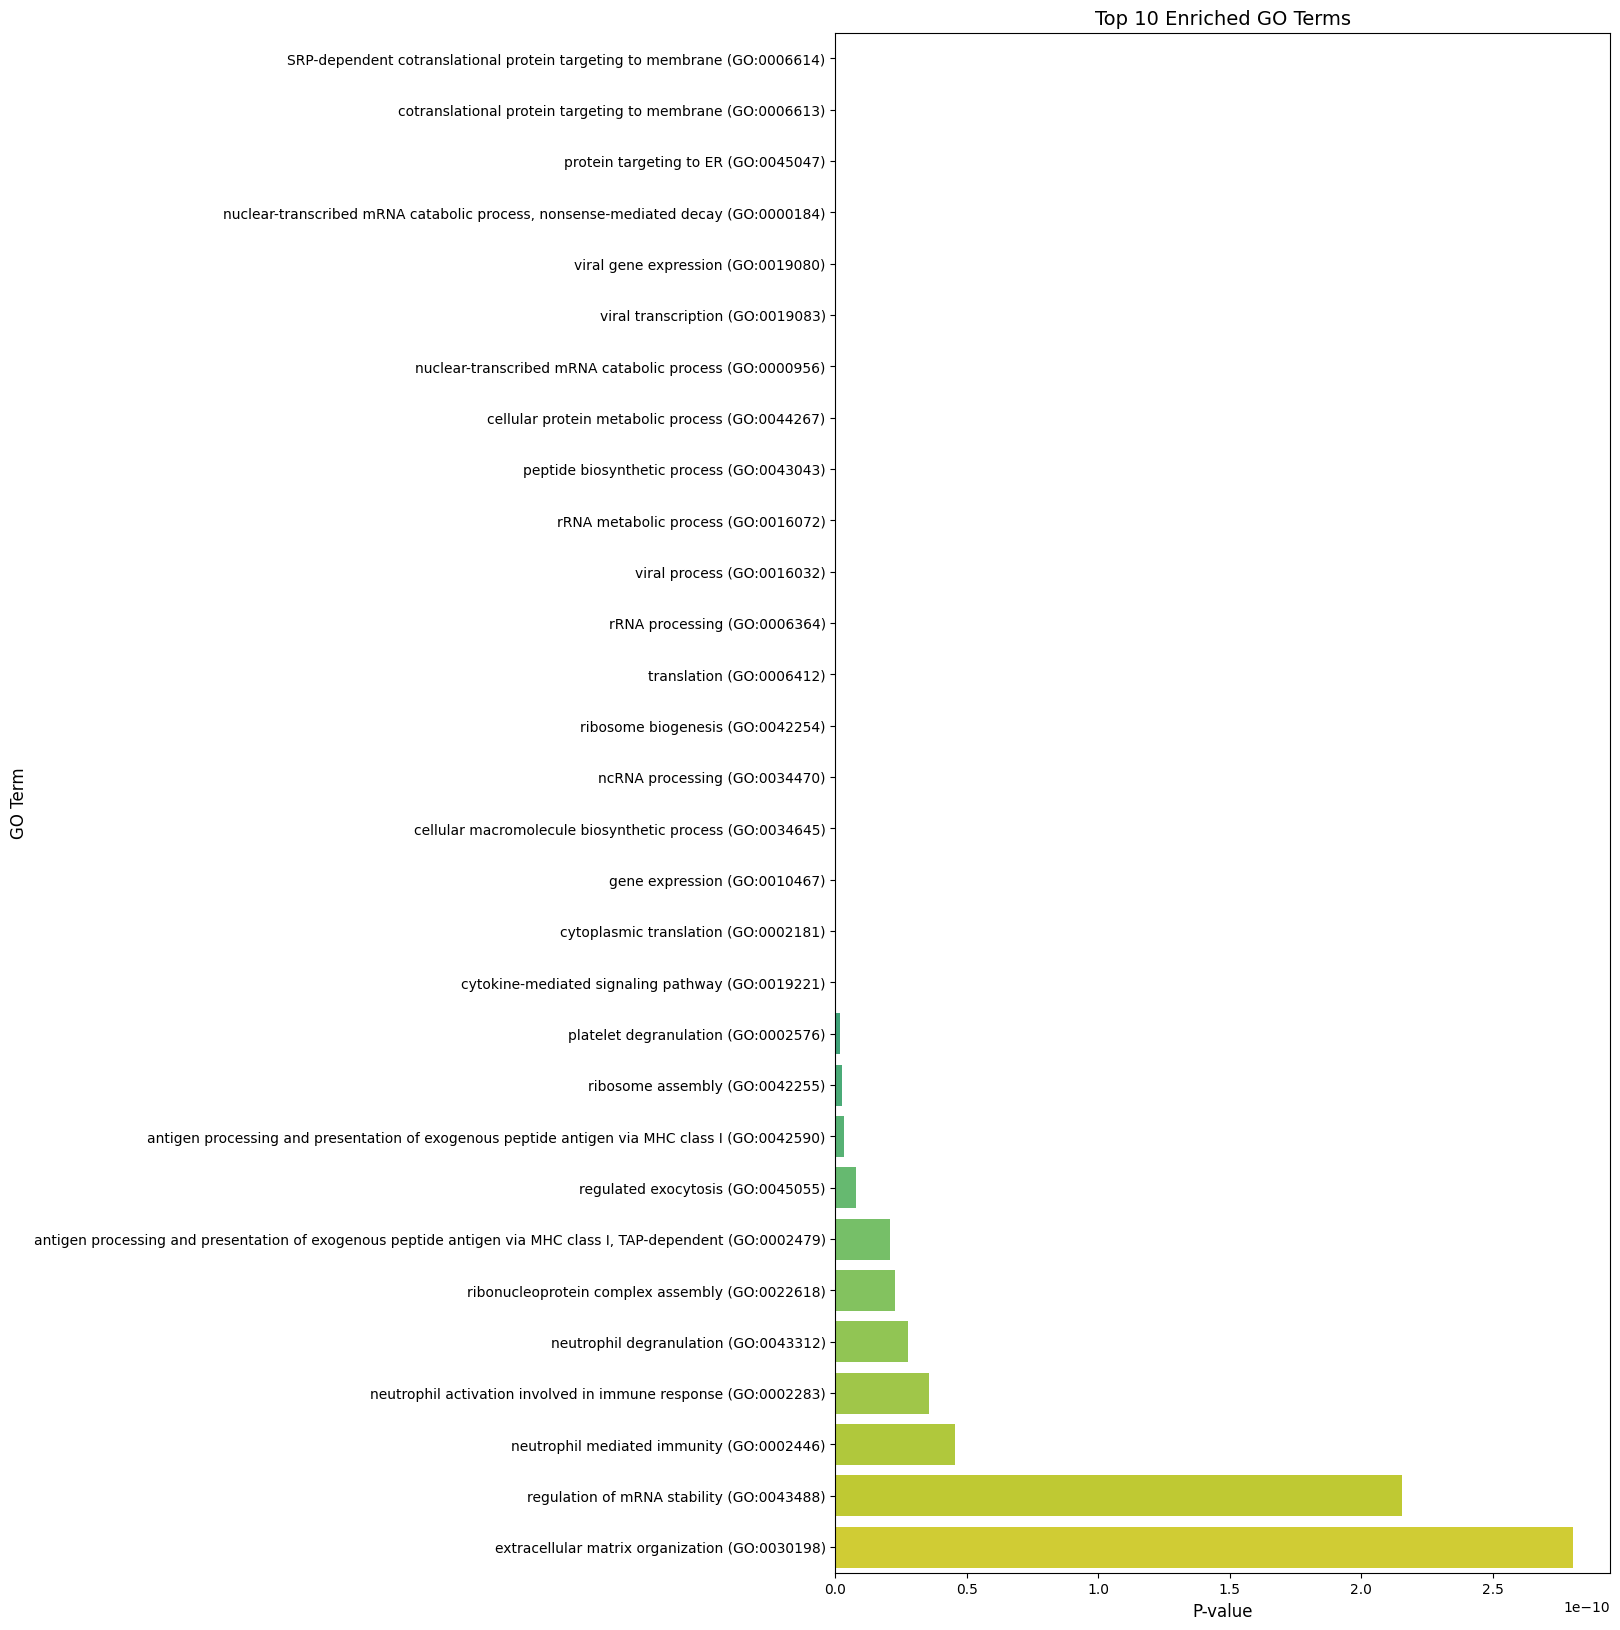

In [40]:
# Sort the results by p-value (ascending order) and get the top 10 terms
enrichment_results = enrichment_results.sort_values(by='P-value').head(30)

# Plotting the top 10 GO terms
plt.figure(figsize=(10, 20))
sns.barplot(x='P-value', y='Term', data=enrichment_results, palette='viridis')

# Add titles and labels
plt.title('Top 10 Enriched GO Terms', fontsize=14)
plt.xlabel('P-value', fontsize=12)
plt.ylabel('GO Term', fontsize=12)

# Show the plot
plt.show()

In [ ]:
#cluster 1

In [27]:
# Filter genes in cluster 1
cluster_1_genes = gene_cluster_df[gene_cluster_df['Cluster'] == 1]['Gene Name'].tolist()

In [41]:
# Perform GO enrichment analysis
enr_cluster_1 = gp.enrichr(
    gene_list=cluster_1_genes,
    gene_sets='GO_Biological_Process_2018',  # You can use different gene sets like BP, MF, CC
    organism='Human',  # Use 'Human' for human genes
    cutoff=0.05  # Only show results with p-value < 0.05
)

# View results
enr_cluster_1.results.head()  # Display top enriched GO terms


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,mitochondrial ATP synthesis coupled electron t...,5/85,5.571712e-10,3.209512e-08,0,0,207.385417,4418.999283,MT-ND4L;MT-ND2;MT-CYB;MT-ND3;MT-ND1
1,GO_Biological_Process_2018,respiratory electron transport chain (GO:0022904),5/94,9.302935e-10,3.209512e-08,0,0,186.329588,3874.820867,MT-ND4L;MT-ND2;MT-CYB;MT-ND3;MT-ND1
2,GO_Biological_Process_2018,"mitochondrial electron transport, NADH to ubiq...",4/46,7.984199e-09,1.836366e-07,0,0,271.387755,5060.242164,MT-ND4L;MT-ND2;MT-ND3;MT-ND1
3,GO_Biological_Process_2018,mitochondrial respiratory chain complex I biog...,3/64,5.062739e-06,5.822150e-05,0,0,122.508197,1493.816296,MT-ND2;MT-ND3;MT-ND1
4,GO_Biological_Process_2018,NADH dehydrogenase complex assembly (GO:0010257),3/64,5.062739e-06,5.822150e-05,0,0,122.508197,1493.816296,MT-ND2;MT-ND3;MT-ND1


In [42]:
# Extract the results from Enrichr
enrichment_results = enr_cluster_1.results

C:\Users\smkts\AppData\Local\Temp\ipykernel_49864\1942653156.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='P-value', y='Term', data=enrichment_results, palette='viridis')


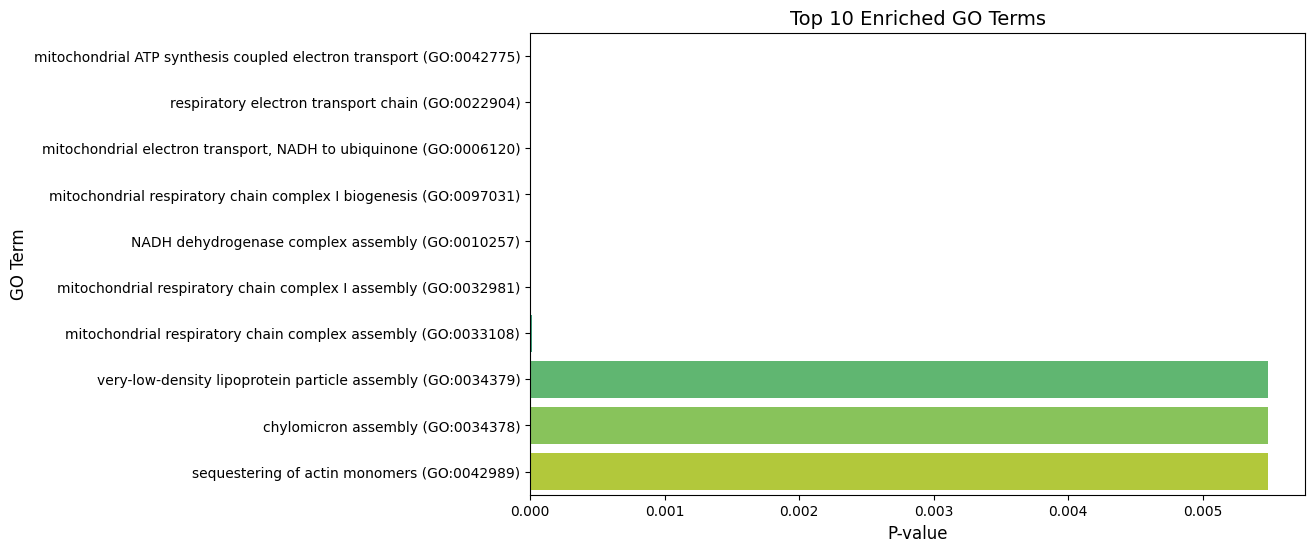

In [43]:
# Sort the results by p-value (ascending order) and get the top 10 terms
enrichment_results = enrichment_results.sort_values(by='P-value').head(10)

# Plotting the top 10 GO terms
plt.figure(figsize=(10, 6))
sns.barplot(x='P-value', y='Term', data=enrichment_results, palette='viridis')

# Add titles and labels
plt.title('Top 10 Enriched GO Terms', fontsize=14)
plt.xlabel('P-value', fontsize=12)
plt.ylabel('GO Term', fontsize=12)

# Show the plot
plt.show()


In [31]:
#cluster 2

In [32]:
cluster_2_genes = gene_cluster_df[gene_cluster_df['Cluster'] == 2]['Gene Name'].tolist()

In [44]:
# Perform GO enrichment analysis
enr_cluster_2 = gp.enrichr(
    gene_list=cluster_2_genes,
    gene_sets='GO_Biological_Process_2018',  # You can use different gene sets like BP, MF, CC
    organism='Human',  # Use 'Human' for human genes
    cutoff=0.05  # Only show results with p-value < 0.05
)

# View results
enr_cluster_2.results.head()  # Display top enriched GO terms

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,mitochondrial ATP synthesis coupled electron t...,4/85,1.513824e-09,2.393101e-08,0,0,983.407407,19971.654318,MT-ND4;MT-CO1;MT-CO2;MT-CO3
1,GO_Biological_Process_2018,respiratory electron transport chain (GO:0022904),4/94,2.279144e-09,2.393101e-08,0,0,884.666667,17604.394360,MT-ND4;MT-CO1;MT-CO2;MT-CO3
2,GO_Biological_Process_2018,"mitochondrial electron transport, cytochrome c...",3/21,9.961417e-09,6.972992e-08,0,0,1664.750000,30672.263741,MT-CO1;MT-CO2;MT-CO3
3,GO_Biological_Process_2018,aerobic respiration (GO:0009060),3/28,2.452403e-08,1.287512e-07,0,0,1198.200000,20996.792273,MT-ND4;MT-CO1;MT-CO3
4,GO_Biological_Process_2018,cellular respiration (GO:0045333),3/57,2.185703e-07,9.179951e-07,0,0,553.916667,8494.953666,MT-ND4;MT-CO1;MT-CO3


In [45]:
# Extract the results from Enrichr
enrichment_results = enr_cluster_2.results

C:\Users\smkts\AppData\Local\Temp\ipykernel_49864\500502918.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='P-value', y='Term', data=enrichment_results, palette='viridis')


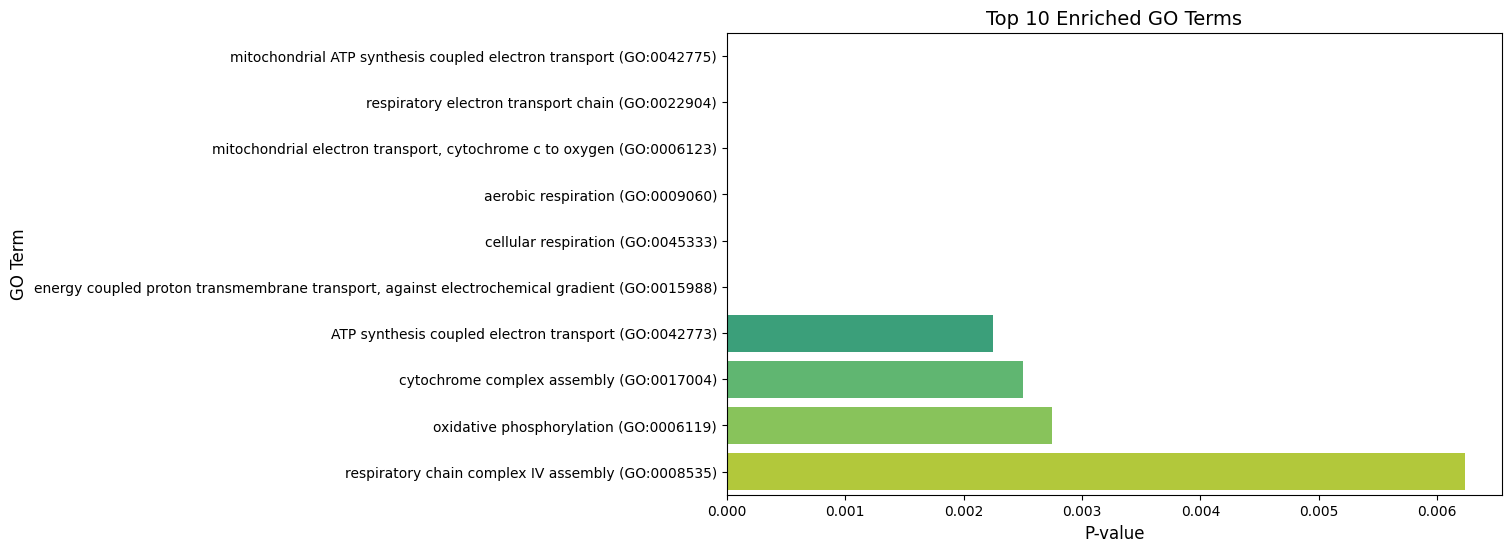

In [46]:
# Sort the results by p-value (ascending order) and get the top 10 terms
enrichment_results = enrichment_results.sort_values(by='P-value').head(10)

# Plotting the top 10 GO terms
plt.figure(figsize=(10, 6))
sns.barplot(x='P-value', y='Term', data=enrichment_results, palette='viridis')

# Add titles and labels
plt.title('Top 10 Enriched GO Terms', fontsize=14)
plt.xlabel('P-value', fontsize=12)
plt.ylabel('GO Term', fontsize=12)

# Show the plot
plt.show()

In [36]:
# cancer pathways

In [47]:
# Define keywords related to cancer pathways
cancer_keywords = ['cancer', 'tumor', 'neoplasm', 'carcinogenesis', 'oncogenesis', 'cell transformation']

# Filter the enrichment results based on cancer-related keywords in the 'Term' column
def filter_cancer_terms(df, keywords):
    return df[df['Term'].str.contains('|'.join(keywords), case=False, na=False)]

# Apply filtering to each cluster's results and add the 'Cluster' column
cancer_enr_cluster_0 = filter_cancer_terms(enr_cluster_0.results, cancer_keywords).assign(Cluster=0)
cancer_enr_cluster_1 = filter_cancer_terms(enr_cluster_1.results, cancer_keywords).assign(Cluster=1)
cancer_enr_cluster_2 = filter_cancer_terms(enr_cluster_2.results, cancer_keywords).assign(Cluster=2)


In [48]:
# Get the top 10 terms for each cluster based on ascending P-value
top_10_cluster_0 = cancer_enr_cluster_0.sort_values(by='P-value', ascending=True).head(10)
top_10_cluster_1 = cancer_enr_cluster_1.sort_values(by='P-value', ascending=True).head(10)
top_10_cluster_2 = cancer_enr_cluster_2.sort_values(by='P-value', ascending=True).head(10)

In [49]:
# Combine the top 10 results from all clusters
combined_top_10_results = pd.concat([top_10_cluster_0, top_10_cluster_1, top_10_cluster_2])

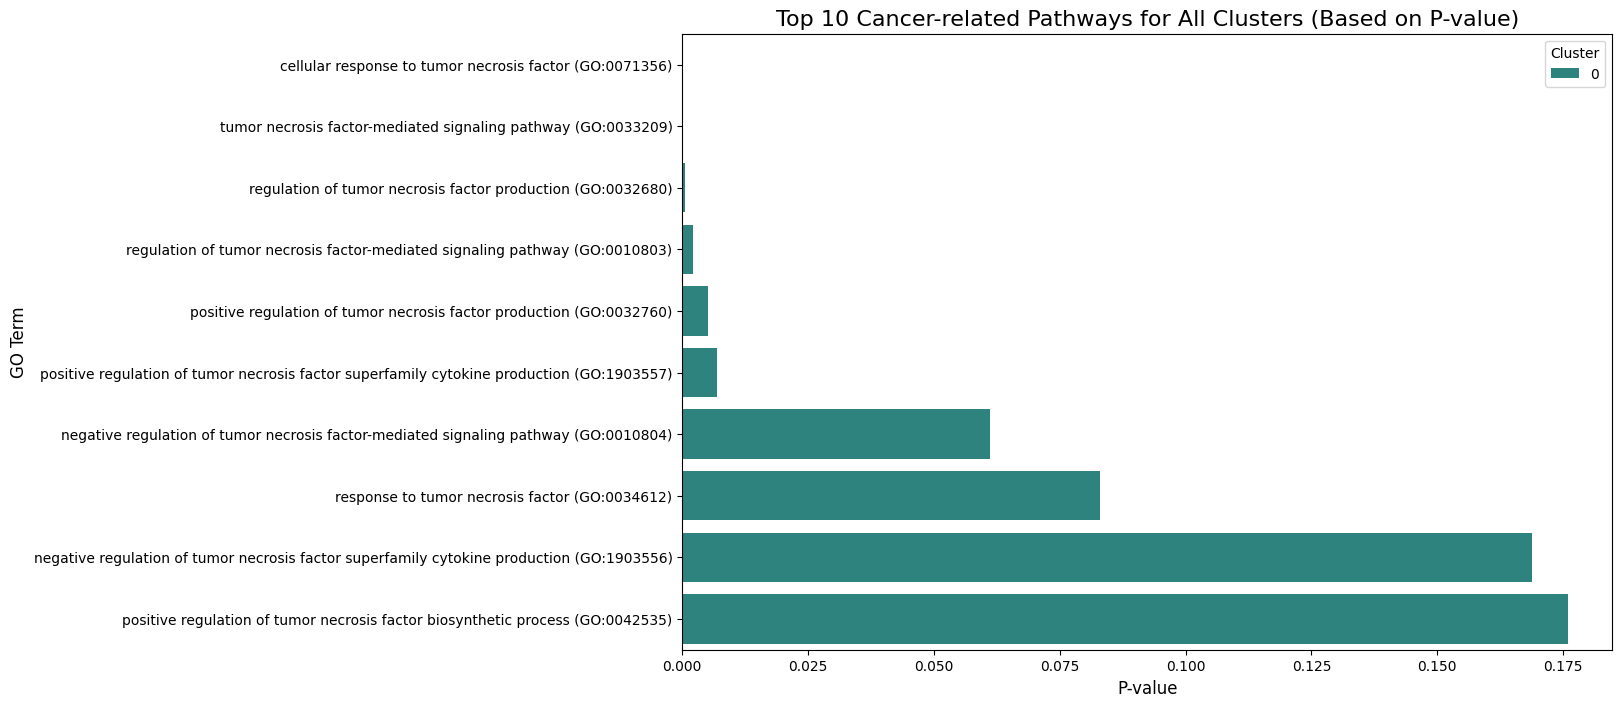

In [50]:
# Plotting using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='P-value', y='Term', hue='Cluster', data=combined_top_10_results, palette='viridis')

# Add titles and labels
plt.title('Top 10 Cancer-related Pathways for All Clusters (Based on P-value)', fontsize=16)
plt.xlabel('P-value', fontsize=12)
plt.ylabel('GO Term', fontsize=12)
plt.legend(title='Cluster')

# Show the plot
plt.show()